In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [3]:
# get the citation data
biodiversity_df = pd.read_csv('land_biodiversity_research.csv')
citations = np.array(biodiversity_df['Times Cited, All Databases'], dtype='int')

C:\Users\btiv\AppData\Local\Temp/ipykernel_24848/478000904.py:2: DtypeWarning: Columns (3,5,7,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  biodiversity_df = pd.read_csv('land_biodiversity_research.csv')


In [4]:
# compute the age of the paper
paper_ages = 2022 - np.array(biodiversity_df['Publication Year'], dtype='int')

In [5]:
paper_df = pd.DataFrame(dict({'Paper Age': paper_ages, 'Citations': citations}))

In [6]:
paper_df = paper_df[paper_df['Paper Age'] <= 25]
paper_df = paper_df[paper_df['Paper Age'] >= 0]
paper_df = paper_df.reset_index(drop=True)

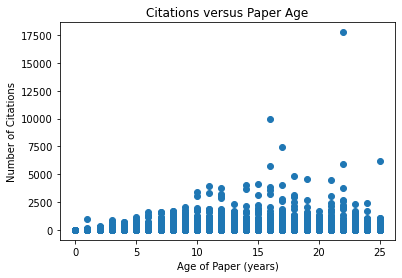

In [7]:
# plot the age of each paper and its citation counts

plt.scatter(paper_df['Paper Age'], paper_df['Citations'])
plt.xlabel('Age of Paper (years)')
plt.ylabel('Number of Citations')
plt.title('Citations versus Paper Age')
plt.show()

In [8]:
popt, pcov = curve_fit(exp_func, paper_df['Paper Age'], paper_df['Citations'], bounds=(0, np.inf), maxfev=5000)

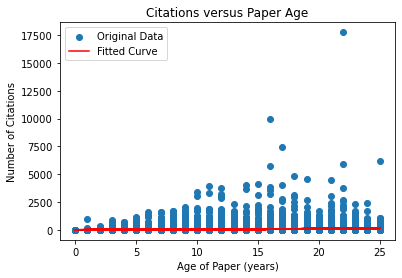

In [9]:
plt.scatter(paper_df['Paper Age'], paper_df['Citations'], label='Original Data')
plt.plot(paper_df['Paper Age'], exp_func(paper_df['Paper Age'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.xlabel('Age of Paper (years)')
plt.ylabel('Number of Citations')
plt.title('Citations versus Paper Age')
plt.show()

In [10]:
popt[0]

13.866492894980022

In [11]:
popt[1]

0.09185321038943173

In [12]:
popt[2]

5.061062607185147e-09

Text(0.5, 1.0, 'Fitted Exponential Function of Citations Given Age')

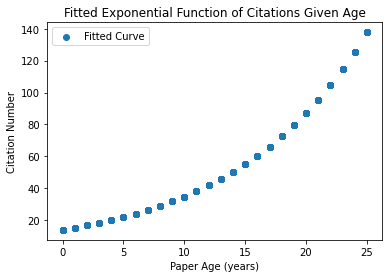

In [13]:
plt.scatter(paper_df['Paper Age'], exp_func(paper_df['Paper Age'], *popt), label='Fitted Curve')
plt.xlabel('Paper Age (years)')
plt.ylabel('Citation Number')
plt.legend()
plt.title('Fitted Exponential Function of Citations Given Age')

citations = $13.87 * e^{0.0919 * \text{paper age}} + 5.06 * 10^{-9}$

In [122]:
# normalize the paper citations by this factor
biodiversity_df['Adjusted Citations'] = biodiversity_df['Times Cited, All Databases'] / exp_func(2022 - biodiversity_df['Publication Year'], *popt)

In [123]:
biodiversity_df['Adjusted Citations']

0         10.247520
1          4.664914
2          4.712710
3         15.909644
4         13.613854
            ...    
150339     0.120027
150340     0.120027
150341     0.120027
150342     0.120027
150343     0.120027
Name: Adjusted Citations, Length: 150344, dtype: float64

In [14]:
def flatten_strip(list):
    # remove extra space around each element in the input list
    return [i.strip() for i in list]

In [15]:
def a_big_one(raw_data,column_name):
    row_before_dropna = raw_data.shape[0] 
    
    cleaned_data = raw_data.dropna(axis=0, subset=[column_name])# delete the row with nan in this column
    row_after_dropna = cleaned_data.shape[0] 
    cleaned_data = cleaned_data.reset_index()
    
    org_nation = {}
    temp_dicts_key_author=[]
    
    for i in range(len(raw_data)):
        string = cleaned_data.loc[i, column_name]

        state = -1

        temp_authors = ''
        temp_adds = ''

        temp_name = []
        temp_country = ''

        temp_dict_key_author={}
        temp_dict_key_org={}

        for s in string:
            if s == '[':
                state = 0
            elif s == ']':
                state = 1
            elif state == 1 and s == ';':
                state = 2

            if state == 0:
                temp_authors+=s
            elif state == 1:
                temp_adds+=s
            elif state == 2 and temp_authors:

                auth = flatten_strip(temp_authors[1:].split(';'))

                add = flatten_strip(temp_adds[2:].split(','))

                org = add[0]


                nation = add[-1].split(' ')[-1]

                temp_authors,temp_adds='',''
                if org not in org_nation.keys():
                    org_nation[org] = nation

                for author in auth:
                    if author in temp_dict_key_author.keys():
                        if (org,org_nation[org]) not in temp_dict_key_author[author]:
                            temp_dict_key_author[author].append((org,org_nation[org]))
                    else:
                        temp_dict_key_author[author] = [(org,org_nation[org])]

        temp_dicts_key_author.append(temp_dict_key_author)
        
    author_num_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        author_num_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add[-1] not in author_num_for_each_country_by_paper[-1].keys():
                    author_num_for_each_country_by_paper[-1][add[-1]] = 1
                else:
                    author_num_for_each_country_by_paper[-1][add[-1]]+=1
                    
                    
    dif_org_for_each_country_by_paper =[]
    for paper in temp_dicts_key_author:
        dif_org_for_each_country_by_paper.append({})
        for author in paper.keys():
            adds = paper[author]
            for add in adds:
                if add not in dif_org_for_each_country_by_paper[-1].keys():
                    dif_org_for_each_country_by_paper[-1][add] = 1
                else:
                    dif_org_for_each_country_by_paper[-1][add]+=1

    return author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation

In [17]:
def get_org_counts(dif_org_for_each_country_by_paper, country_str):
    org_counts = []
    for index, paper_dict in enumerate(dif_org_for_each_country_by_paper):
        org_count = 0
        for key in dif_org_for_each_country_by_paper[index].keys():
            if country_str in key:
                org_count += 1
        org_counts.append(org_count)
    return org_counts

def get_author_counts(author_num_for_each_country_by_paper, country_str):
    author_counts = []
    for index, paper_dict in enumerate(author_num_for_each_country_by_paper):
        author_count = 0
        for key in author_num_for_each_country_by_paper[index].keys():
            if country_str in key:
                author_count += author_num_for_each_country_by_paper[index][key]
        author_counts.append(author_count)
    return author_counts

In [18]:
# read in each country dataframe and perform feature engineering
protected_df = pd.read_csv('protected_land_cleaned.csv')
for country_str in protected_df['Country'].unique()[:len(protected_df['Country'].unique()) - 1]:
    country_research_df = pd.read_csv(f"{country_str}_biodiversity_research.csv")
    
    # paper age and adjusted citations
    country_research_df['Paper Age'] = 2022 - country_research_df['Publication Year']
    country_research_df['Adjusted Citations'] = country_research_df['Times Cited, All Databases'] / exp_func(country_research_df['Paper Age'], *popt)
    author_num_for_each_country_by_paper,dif_org_for_each_country_by_paper,org_nation = a_big_one(country_research_df, 'Addresses')
    
    mod_string = country_str
    if country_str == 'United States':
        mod_string = 'USA'
    elif country_str == "China (People's Republic of)":
        mod_string = 'China'
        
    author_counts = get_author_counts(author_num_for_each_country_by_paper, mod_string)
    org_counts = get_org_counts(dif_org_for_each_country_by_paper, mod_string)
    
    # number of authors from given country per paper
    country_research_df['Country Specific Authors'] = author_counts
    
    # number of organizations in a given country per paper
    country_research_df['Country Specific Orgs'] = org_counts
    
    # write new research df to file
    country_research_df.to_csv(f"{country_str}_biodiversity_research.csv")

C:\Users\btiv\AppData\Local\Temp/ipykernel_24848/3999267649.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  country_research_df = pd.read_csv(f"{country_str}_biodiversity_research.csv")
C:\Users\btiv\AppData\Local\Temp/ipykernel_24848/3999267649.py:4: DtypeWarning: Columns (10,14,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  country_research_df = pd.read_csv(f"{country_str}_biodiversity_research.csv")
C:\Users\btiv\AppData\Local\Temp/ipykernel_24848/3999267649.py:4: DtypeWarning: Columns (5,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  country_research_df = pd.read_csv(f"{country_str}_biodiversity_research.csv")
C:\Users\btiv\AppData\Local\Temp/ipykernel_24848/3999267649.py:4: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  country_research_df = pd.read_csv(f"{country_str}_biodiversity_research.csv"